# Exploring Datasets from FREMTPL2
Dr John Raine

## Exercise

* Explorative data analysis
* Feature engineering
* Model evaluation
* Model building

## Datasets

Two datasets in `.arff` format


In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pathlib

import arff


In [2]:
datapath = pathlib.Path('./data/')
freq_datapath = datapath / 'freMTPL2freq.arff'
sev_datapath = datapath / 'freMTPL2sev.arff'

In [3]:
def load_arff_pd(filepath):#, indexvar='IDpol'):
    '''Function to load an arff file and return a pandas DataFrame
    Input: 
      filepath: path to file
    Returns:
      Pandas DataFrame
    '''
    #open arff file, using liac-arff, not familiar with format
    #There must be better loading tools or libraries compatible directly with this format
    #However I am unfamiliar with it
    data = arff.load(open(filepath,'r'))
    #convert to pandas dataframe
    cols = [x[0] for x in data['attributes']]
    df = pd.DataFrame(data=data['data'],columns=cols)
    #64->32bit precision, turn objects back into categories

    for col,dtype in zip(df.columns,df.dtypes):
        if dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif dtype == 'object':
            df[col] = df[col].astype('category')
    return df

Difficulties with data:
* Not a familiar (to me) format
* Different lengths of datasets, check that all ids from sev are also in freq, likely lists only claimants
* Categorical inputs as well as numerical, need to handle for downstream tasks
* Check balance and properties of data, target needs understanding still - most drivers not involved in incidents, many zeros in target

In [4]:
fq_df = load_arff_pd(str(freq_datapath))
sv_df = load_arff_pd(str(sev_datapath))

In [5]:
fq_df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72


In [6]:
_,counts = np.unique(fq_df.IDpol,return_counts=True) # Check IDpolicies only once
np.unique(counts)

array([1])

In [7]:
sv_df

,IDpol,ClaimAmount
0,1552.0,995.200012
1,1010996.0,1128.119995
2,4024277.0,1851.109985
3,4007252.0,1204.000000
4,4046424.0,1204.000000
...,...,...
26634,3254353.0,1200.000000
26635,3254353.0,1800.000000
26636,3254353.0,1000.000000
26637,2222064.0,767.549988


In [8]:
_,counts=np.unique(sv_df.IDpol,return_counts=True) # Are IDpol multiple times
np.unique(counts)

array([ 1,  2,  3,  4,  5,  6,  8,  9, 11, 16, 21, 23, 24, 25, 36, 66])

Can see that the claims are entered individually, not grouped by policy. Have no indication of when the claims were made
Suggestions:
* I would include date, can now start looking into claims as function of time, rolling cost over 1, 2, 3, 4, 5 years
* For now, will take the sum over each ID as a total cost


First checking whether all IDs in sev are also in freq dataset using np.in1d
Using ~ operator to invert bool and any to test if any are False

In [9]:

~(np.in1d(np.unique(sv_df['IDpol']),np.unique(fq_df['IDpol']))).any()


False

Now to merge the datasets together including claim amounts

In [10]:
sv_df = sv_df.groupby('IDpol').sum() # first sum claim amounts to be one per ID
sv_df.head()

,ClaimAmount
IDpol,
139.0,303.000000
190.0,1981.839966
414.0,1456.550049
424.0,10834.000000
463.0,3986.669922


In [11]:
#Now joining datasets together based on index, idpol now unique, can use as index for joining
df = fq_df.join(sv_df,on='IDpol').sort_index()
df.ClaimAmount = df.ClaimAmount.fillna(0.0)
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
3,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0


In [12]:
df[df.ClaimAmount > 0].head()#check there are the right claim amounts

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
66,139.0,1.0,0.75,F,7.0,1.0,61.0,50.0,B12,Regular,27000.0,R11,303.000000
93,190.0,1.0,0.14,B,12.0,5.0,50.0,60.0,B12,Diesel,56.0,R25,1981.839966
199,414.0,1.0,0.14,E,4.0,0.0,36.0,85.0,B12,Regular,4792.0,R11,1456.550049
205,424.0,2.0,0.62,F,10.0,0.0,51.0,100.0,B12,Regular,27000.0,R11,10834.000000
223,463.0,1.0,0.31,A,5.0,0.0,45.0,50.0,B12,Regular,12.0,R73,3986.669922


In [13]:
sv_df.sort_index().head()#all looks good

,ClaimAmount
IDpol,
139.0,303.000000
190.0,1981.839966
414.0,1456.550049
424.0,10834.000000
463.0,3986.669922


Now have a single dataset to work from with claims grouped per policy, can do small investigation into whether missing info in rest of columns and trends with respect to ClaimAmount/Exposure

In [14]:
df.isna().any()

IDpol          False
ClaimNb        False
Exposure       False
Area           False
VehPower       False
VehAge         False
DrivAge        False
BonusMalus     False
VehBrand       False
VehGas         False
Density        False
Region         False
ClaimAmount    False
dtype: bool

In [15]:
df['YearCost'] = df.ClaimAmount/df.Exposure
df['AvgClaim'] = (df.ClaimAmount/df.ClaimNb).fillna(0)

Check for reasonable values

In [109]:
df.min(),df.max()

/tmp/ipykernel_29876/2878880083.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.min(),df.max()


(IDpol           1.000000
 ClaimNb         0.000000
 Exposure        0.002732
 VehPower        4.000000
 VehAge          0.000000
 DrivAge        18.000000
 BonusMalus     50.000000
 Density         1.000000
 ClaimAmount     0.000000
 YearCost        0.000000
 AvgClaim        0.000000
 dtype: float32,
 IDpol           6114330.00
 ClaimNb              16.00
 Exposure              2.01
 VehPower             15.00
 VehAge              100.00
 DrivAge             100.00
 BonusMalus          230.00
 Density           27000.00
 ClaimAmount     4075400.50
 YearCost       18524548.00
 AvgClaim        4075400.50
 dtype: float32)

Definitely looks like there are outliers in the claim amount and year cost!

Text(0, 0.5, 'Counts')

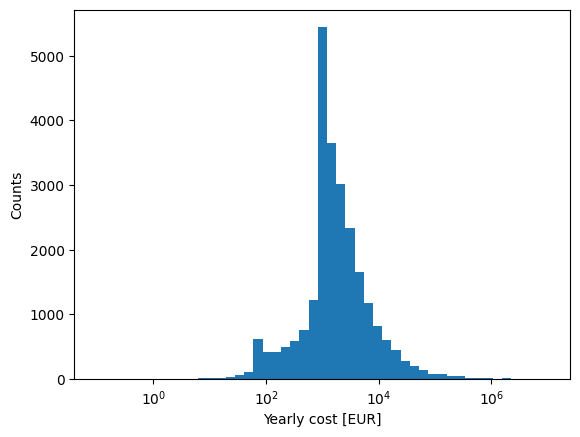

In [130]:
plt.hist(df['YearCost'],bins=np.logspace(-1,7)) 
plt.semilogx()#won't show zeros on logscale
plt.xlabel('Yearly cost [EUR]')
plt.ylabel('Counts')

In [16]:
indvars = list(df.columns)
for v in ['IDpol','ClaimNb','Exposure','ClaimAmount','YearCost','AvgClaim']:
    indvars.remove(v)
print(indvars)

['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']


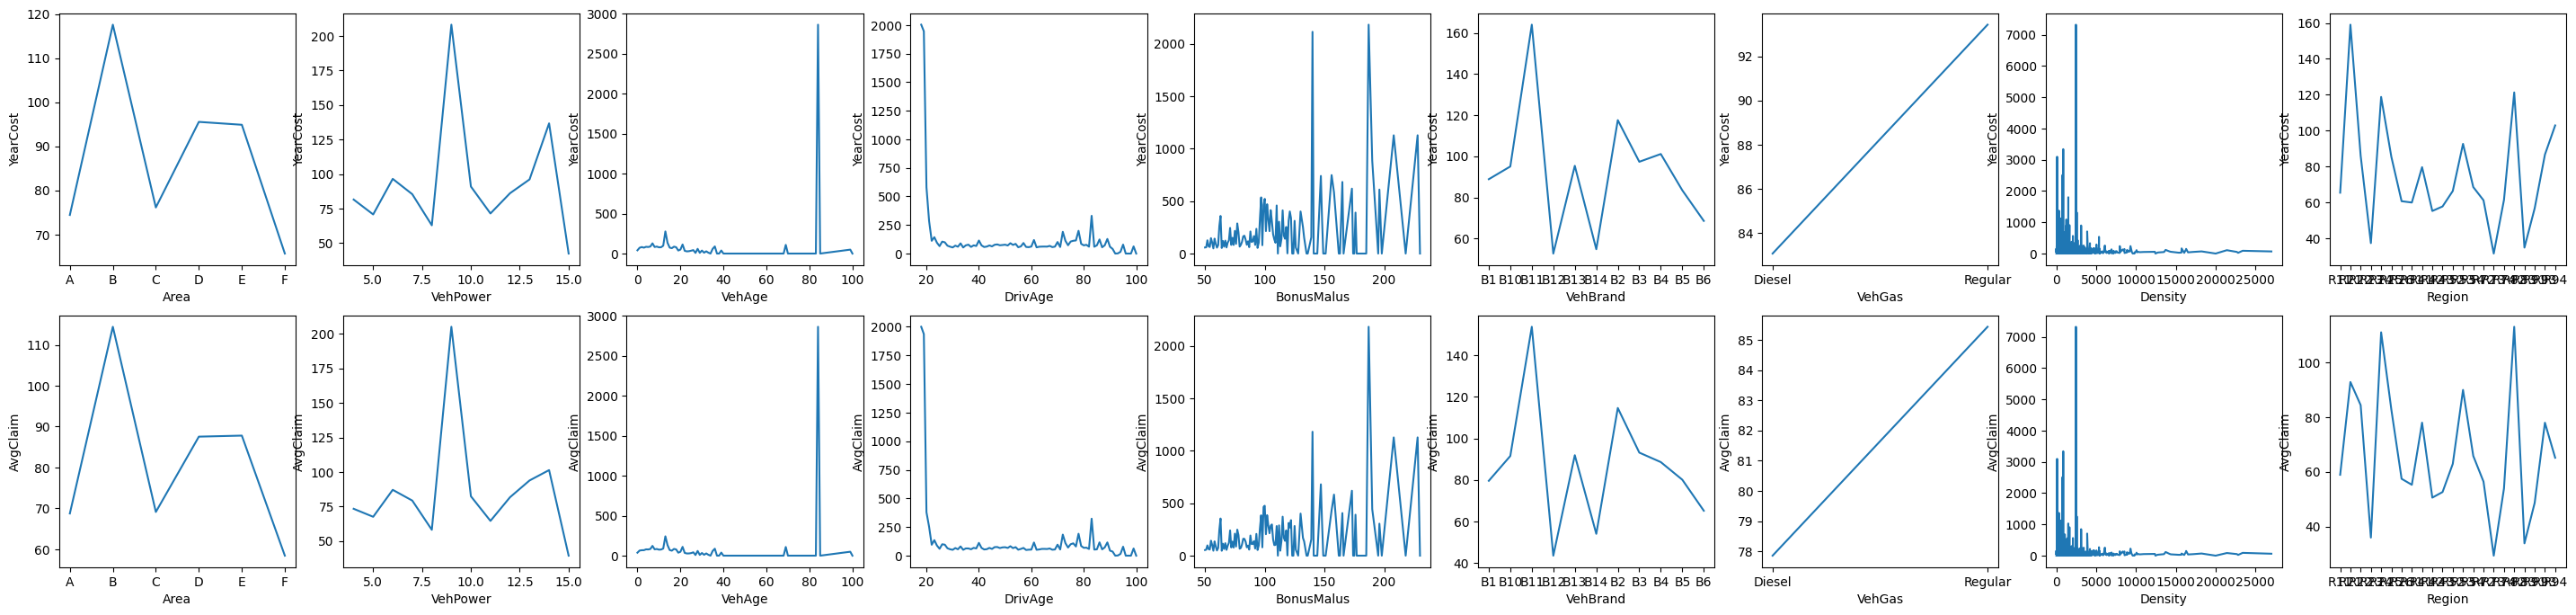

In [17]:
fig,axes = plt.subplots(nrows=2,ncols=len(indvars),figsize=(4*len(indvars),8))
for v,ax1,ax2 in zip(indvars,axes[0],axes[1]):
    data1 = df.groupby([v]).mean()['ClaimAmount']
    data2 = df.groupby([v]).mean()['AvgClaim']
    if df[v].dtype == 'float32':
        df[v]
        ax1.plot(data1.index,data1.values)
        ax2.plot(data2.index,data2.values)
        for ax in [ax1,ax2]:
            ax.set_xlabel(v)
    else:
        cattype = df[v].dtype
        catlabels = cattype.categories.to_list()
        ncats = len(catlabels)

        bins = np.arange(0,ncats,1)
        ax1.plot(bins,data1.values)
        ax2.plot(bins,data2.values)
        for ax in [ax1,ax2]:
            ax.set_xlabel(v)
            ax.set_xticks(bins,catlabels)
for ax1,ax2 in zip(axes[0],axes[1]):
    ax1.set_ylabel('YearCost')
    ax2.set_ylabel('AvgClaim')


Can see that rough groupby not great for density or bonus malus (continuous variables) but can already make conclusions#

Statistics play a keen role in many of trends, higher age and bonus malus are less frequent, become more variable - adapt binning of distributions

Can see that e.g. vehicle age dominated by low stat effects in tail, one value with high claim

Not as dramatic in age but also apparent.



Few takeaways:
* Some key features are:
  * Vehicle Age, Driver age
  * Bonus malus
  * Pop density plays a role, less densley populated contributes to higher claims
* Need to make density but cost weighted in histogram to better understand contribution
* Categorical features show strong variation, area, region, brand
* Many distributions are long tailed



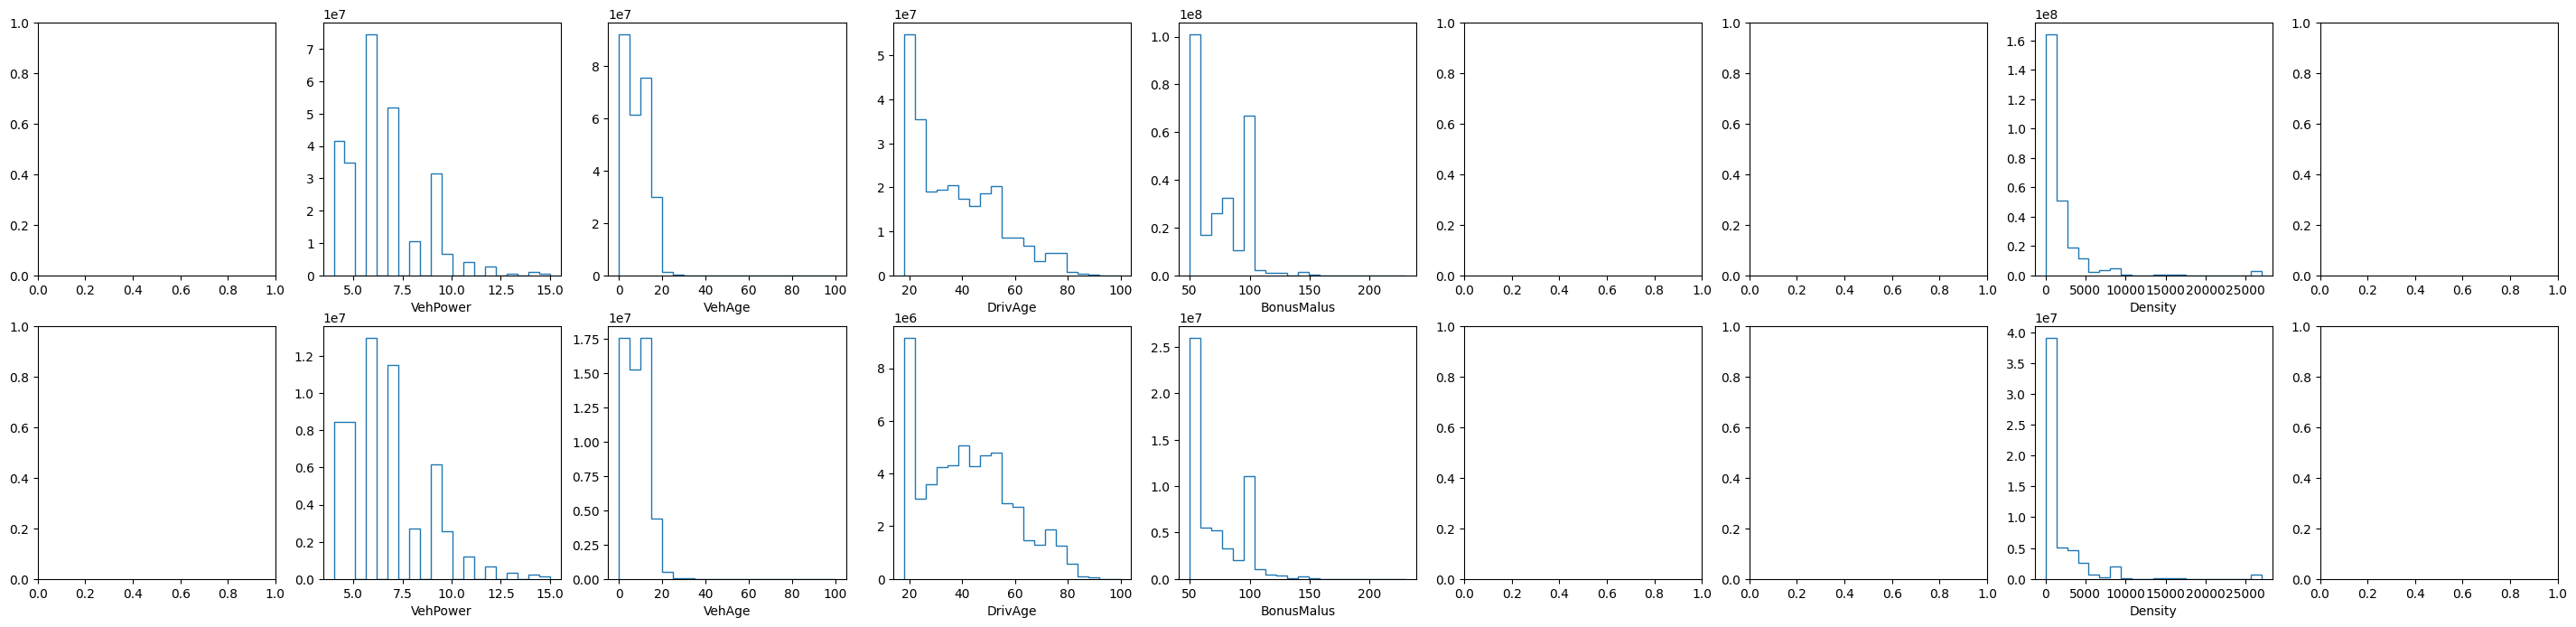

In [18]:
fig,axes = plt.subplots(nrows=2,ncols=len(indvars),figsize=(4*len(indvars),8))
for v,ax1,ax2 in zip(indvars,axes[0],axes[1]):
    if df[v].dtype == 'float32':
        ax1.hist(df[v],weights=df['YearCost'],bins=20,histtype='step')
        ax2.hist(df[v],weights=df['AvgClaim'],bins=20,histtype='step')
        for ax in [ax1,ax2]:
            ax.set_xlabel(v)
### Can for sure make these look nicer, get uncertainties but for now will do; this is also now cost per bracket not normalised per frequency~

Repeating this with median results in zeros due to nature of dataset - most ID make no claims, need therefore to have an idea of expected cost which is seen above as individual functions

Decision tree likely sufficient for the task, especially due to categorical inputs

Can also look at linear correlation matrix between non categorical inputs, year cost and average claim

In [104]:
df.corr()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,YearCost,AvgClaim
IDpol,1.000000,-0.127949,-0.160152,0.048610,-0.156919,0.063703,-0.005595,0.070759,-0.003894,-0.002802,-0.003943
ClaimNb,-0.127949,1.000000,0.068909,-0.004259,-0.021768,0.011392,0.050544,0.010754,0.071185,0.048224,0.062738
Exposure,-0.160152,0.068909,1.000000,-0.045259,0.151554,0.171873,-0.183018,-0.071085,0.002244,-0.008517,0.002313
VehPower,0.048610,-0.004259,-0.045259,1.000000,-0.006001,0.030108,-0.075895,0.042901,0.001275,0.000183,0.001330
VehAge,-0.156919,-0.021768,0.151554,-0.006001,1.000000,-0.059213,0.079923,-0.090428,0.002321,0.001413,0.002468
DrivAge,0.063703,0.011392,0.171873,0.030108,-0.059213,1.000000,-0.479966,-0.004700,-0.003663,-0.005839,-0.003495
BonusMalus,-0.005595,0.050544,-0.183018,-0.075895,0.079923,-0.479966,1.000000,0.077717,0.009956,0.008930,0.009424
Density,0.070759,0.010754,-0.071085,0.042901,-0.090428,-0.004700,0.077717,1.000000,-0.000056,-0.000141,-0.000093
ClaimAmount,-0.003894,0.071185,0.002244,0.001275,0.002321,-0.003663,0.009956,-0.000056,1.000000,0.684834,0.985933
YearCost,-0.002802,0.048224,-0.008517,0.000183,0.001413,-0.005839,0.008930,-0.000141,0.684834,1.000000,0.687658


Can see that as most people claim only once, YearCost and AvgClaim are very similar

For linear correlations the overall values are quite small, but can see from some distributions it is non linear relationship
Also very dominated by those with zero claims


In [105]:
df[df['ClaimAmount']>0].corr()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,YearCost,AvgClaim
IDpol,1.000000,0.040580,-0.097909,0.059482,-0.095685,0.054924,-0.025230,0.066987,-0.003114,-0.002849,-0.003999
ClaimNb,0.040580,1.000000,-0.010170,-0.008170,-0.022177,-0.004781,0.055597,0.027491,0.032681,0.019781,0.005557
Exposure,-0.097909,-0.010170,1.000000,-0.015793,0.007107,0.191250,-0.132257,-0.047306,-0.027809,-0.079990,-0.025965
VehPower,0.059482,-0.008170,-0.015793,1.000000,-0.015646,0.022266,-0.069155,0.045348,0.006226,0.000588,0.006538
VehAge,-0.095685,-0.022177,0.007107,-0.015646,1.000000,-0.071705,0.138950,-0.077709,0.008047,0.004489,0.009070
DrivAge,0.054924,-0.004781,0.191250,0.022266,-0.071705,1.000000,-0.471575,0.001863,-0.016527,-0.028068,-0.015745
BonusMalus,-0.025230,0.055597,-0.132257,-0.069155,0.138950,-0.471575,1.000000,0.047665,0.020335,0.022560,0.018850
Density,0.066987,0.027491,-0.047306,0.045348,-0.077709,0.001863,0.047665,1.000000,-0.003980,-0.003238,-0.004035
ClaimAmount,-0.003114,0.032681,-0.027809,0.006226,0.008047,-0.016527,0.020335,-0.003980,1.000000,0.683731,0.985855
YearCost,-0.002849,0.019781,-0.079990,0.000588,0.004489,-0.028068,0.022560,-0.003238,0.683731,1.000000,0.686569


Looking only at those who have claimed can see trend of:
 * higher exposure, lower year cost
 * higher bonusmalus, higher year cost
 * higher age, lower year cost
 * higher density small effect in lowering cost

In [ ]:

from utils import cat_to_onehot, mean_std_floats, inverse_transform_floats
from dataset import load_merged_dataframe

In [20]:
idx = np.arange(0,len(df),1)
np.random.shuffle(idx)

In [21]:
floatvars = ['VehAge', 'DrivAge', 'BonusMalus', 'Density']
# Area, VehBrand, VehGas, VehPower, Region: categorical
catvars =  ['Area', 'VehBrand', 'VehGas', 'VehPower', 'Region']
x_float = df[floatvars].iloc[idx[:int(0.6*len(df))]]
x_cat = df[catvars].iloc[idx[:int(0.6*len(df))]]

In [23]:
idx = np.arange(0,len(df),1)
np.random.shuffle(idx)
from utils import cat_to_onehot, mean_std_floats, inverse_transform_floats

# Choose input features to method
# VehAge, DrivAge, BonusMalus, Density: floats
floatvars = ['VehAge', 'DrivAge', 'BonusMalus', 'Density']
# Area, VehBrand, VehGas, VehPower, Region: categorical
catvars =  ['Area', 'VehBrand', 'VehGas', 'VehPower', 'Region']

# Get training set, use these for float conversion
x_float_train, float_trafo = mean_std_floats(df.iloc[idx[:int(0.6*len(df))]],
                                        floatvars)

x_float_val,_ = mean_std_floats(df.iloc[idx[int(0.6*len(df)):int(0.8*len(df))]],
                        floatvars,
                        float_trafo)

x_float_test,_ = mean_std_floats(df.iloc[idx[int(0.8*len(df)):]],
                        floatvars,
                        float_trafo)

x_cat = cat_to_onehot(df,catvars)
x_cat_train = x_cat[idx[:int(0.6*len(df))]]
x_cat_val = x_cat[idx[int(0.6*len(df)):int(0.8*len(df))]]
x_cat_test = x_cat[idx[int(0.8*len(df)):]]

In [24]:
# Get target, learn scaling from train
y_train, target_trafo = mean_std_floats(df.iloc[idx[:int(0.6*len(df))]],
                                        ['YearCost'])

y_val,_ = mean_std_floats(df.iloc[idx[int(0.6*len(df)):int(0.8*len(df))]],
                            ['YearCost'],
                            target_trafo)

y_test,_ = mean_std_floats(df.iloc[idx[int(0.8*len(df)):]],
                                ['YearCost'],
                                target_trafo)


In [64]:
from sklearn.ensemble import GradientBoostingRegressor

# Hyperparameters for boosted regression tree
criterion = 'squared_error'
learning_rate = 0.1
n_estimators = 100
subsample = 1.0
max_depth = 4
min_samples_split = 2
max_features = None

regressor = GradientBoostingRegressor(criterion=criterion,
                                      learning_rate=learning_rate,
                                      n_estimators=n_estimators,
                                      subsample=subsample,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      max_features=max_features,
                                      random_state=0)

regressor.fit(np.concatenate([x_float_train,x_cat_train],axis=1),y_train.ravel())

GradientBoostingRegressor(criterion='squared_error', max_depth=4,
                          random_state=0)

In [65]:
val_preds = regressor.predict(np.concatenate([x_float_val, x_cat_val],axis=1))
test_preds = regressor.predict(np.concatenate([x_float_test, x_cat_test],axis=1))
train_preds = regressor.predict(np.concatenate([x_float_train, x_cat_train],axis=1))

Text(0, 0.5, 'Counts')

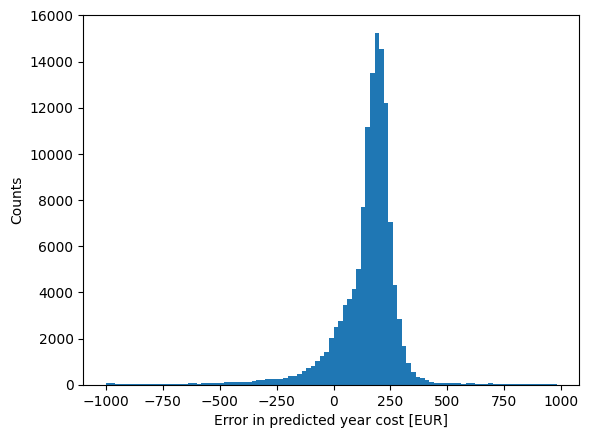

In [107]:
import matplotlib.colors as mcol
plt.hist(target_trafo.inverse_transform((y_val.ravel()-val_preds.ravel()).reshape(-1,1)).ravel(),bins=np.arange(-1000,1000,20))
plt.xlabel('Error in predicted year cost [EUR]')
plt.ylabel('Counts')


Can see that there is a severe underestimation in cost per year

Training on dataset dominated by zero cost

Need a difference approach:
* Predict expected claims per year
* Predict expected amount per claim

In [131]:
df['ClaimYear'] = (df.ClaimNb/df.Exposure).fillna(0)
df['ClaimCost'] = (df.ClaimAmount/df.ClaimNb).fillna(0)

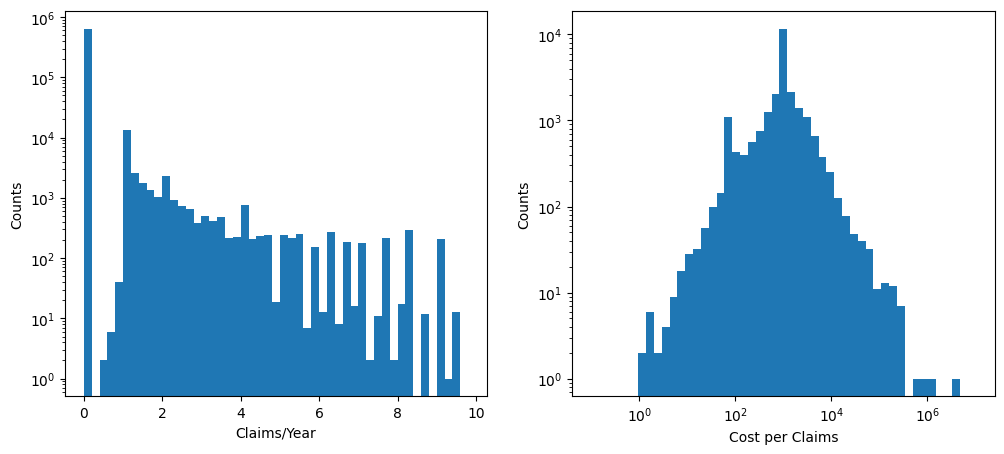

In [138]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
axes[0].hist(df['ClaimYear'],bins=np.arange(0,10,0.2))
axes[0].semilogy()
axes[0].set_xlabel('Claims/Year')
axes[1].hist(df['ClaimCost'],bins=np.logspace(-1,7))
axes[1].semilogy()
axes[1].semilogx()
axes[1].set_xlabel('Cost per Claims')
for ax in axes:
    ax.set_ylabel('Counts')

Can weight the claims/year by the relative cost per year, making distribution flatter, however now the zero is (for clear reasons) gone and no longer represented

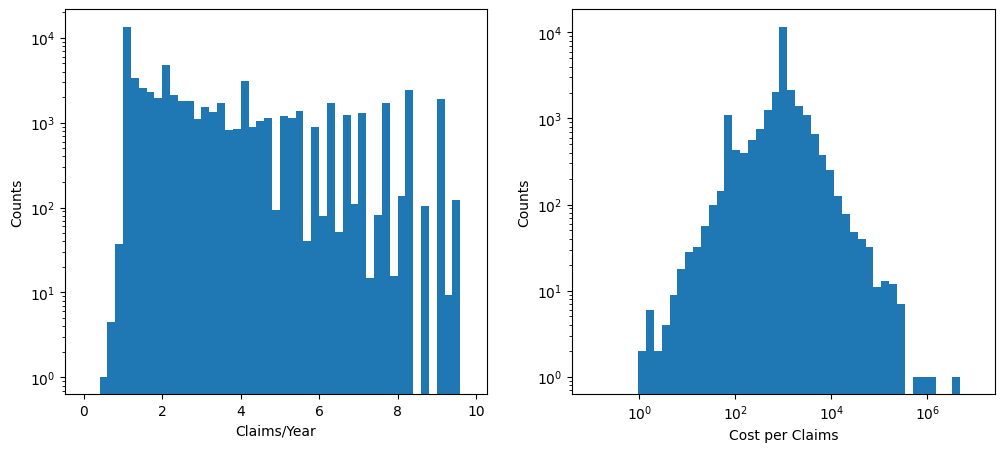

In [139]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
axes[0].hist(df['ClaimYear'],bins=np.arange(0,10,0.2),weights=df['ClaimYear'])
axes[0].semilogy()
axes[0].set_xlabel('Claims/Year')
axes[1].hist(df['ClaimCost'],bins=np.logspace(-1,7))
axes[1].semilogy()
axes[1].semilogx()
axes[1].set_xlabel('Cost per Claims')
for ax in axes:
    ax.set_ylabel('Counts')